# Preparation 

In [1]:
import os
import glob
import time
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import torch.nn.parameter as P
import torchvision
from torchvision import transforms, datasets

# Define Neural Network

## Building blocks of the architecture 

In [3]:
class MyBatchNormalization2d(nn.Module):
    """Class containing custom implementation of batch normalization.
    """
    def __init__(self, size, momentum=0.1, epsilon=1e-5):
        """Derived constructor.
        
        :param size: Number of channels in input tensor.
        :param momentum: How fast shall running mean and std decay?
        :param epsilon: Number to add to standard deviation to aviod zeros.
        :return: MyBatchNormalization2d object."""
        super(MyBatchNormalization2d, self).__init__()
        self.register_buffer('epsilon', torch.Tensor([epsilon]))
        self.register_buffer('momentum',  torch.Tensor([momentum]))
        self.register_buffer('running_mean', torch.zeros(size))
        self.register_buffer('running_std', torch.ones(size))
        self.shift = P.Parameter(torch.Tensor(size))
        self.scale = P.Parameter(torch.Tensor(size))
        init.zeros_(self.shift)
        init.uniform_(self.scale)
        
    def forward(self, x):
        """Method implementing batch normalization logic.
        
        :param x: Input tensor of shape (N x C x W x H).
        :return: Batch normalized x."""
        # Compute running means and stds per channel
        batch_size, channels, width, height = x.size()
        
        x_agg = x.permute((1, 0, 2, 3))\
                 .contiguous()\
                 .view(-1, batch_size * width * height)
        
        if self.training:
            tmp_mean = torch.mean(x_agg, dim=1)
            tmp_std = torch.std(x_agg, dim=1, unbiased=True)
            
            self.running_mean = (1. - self.momentum) * self.running_mean +\
                self.momentum * tmp_mean.detach()
            self.running_std = (1. - self.momentum) * self.running_std +\
                self.momentum * tmp_std.detach()
        
        # Scale input to have 0 mean and unit variance (remeber about epsilon!)
        tensor_mean = x.new_ones(width, height)
        tensor_std = torch.diag(x.new_ones(height)) 
        
        if self.training:
            tensor_means = torch.stack([tensor_mean * tmp_mean[i] for i in range(channels)])
            tensor_stds = torch.stack([tensor_std * (1 / (tmp_std[i] + self.epsilon)) for i in range(channels)])            
        else:
            tensor_means = torch.stack([tensor_mean * self.running_mean[i] for i in range(channels)])
            tensor_stds = torch.stack([tensor_std * (1 / (self.running_std[i] + self.epsilon)) for i in range(channels)])
            
        x = torch.matmul((x - tensor_means), tensor_stds)
        
        # Scale input using parameters
        tensor_shift = torch.stack([tensor_mean * self.shift[i] for i in range(channels)])
        tensor_scale = torch.stack([tensor_std * self.scale[i] for i in range(channels)])
        x = torch.matmul(x, tensor_scale) + tensor_shift
        
        # Return the result
        return x

In [4]:
class MyBatchNormalization1d(nn.Module):
    def __init__(self, size, momentum=0.1, epsilon=1e-5):
        """Derived constructor.
        
        :param size: Number of linear features in input tensor.
        :param momentum: How fast shall running mean and std decay?
        :param epsilon: Number to add to standard deviation to aviod zeros.
        :return: MyBatchNormalization2d object."""
        super(MyBatchNormalization1d, self).__init__()
        self.register_buffer('epsilon', torch.Tensor([epsilon]))
        self.register_buffer('momentum',  torch.Tensor([momentum]))
        self.register_buffer('running_mean', torch.zeros(size))
        self.register_buffer('running_std', torch.ones(size))
        self.shift = P.Parameter(torch.Tensor(size))
        self.scale = P.Parameter(torch.Tensor(size))
        init.zeros_(self.shift)
        init.uniform_(self.scale)
        
    def forward(self, x):
        """Method implementing batch normalization logic.
        
        :param x: Input tensor of shape (N x L).
        :return: Batch normalized x."""
        # Compute running means and stds per batch
        batch_size, features_size = x.size()
        
        if self.training:
            tmp_mean = torch.mean(x, dim=0)
            tmp_std = torch.std(x, dim=0, unbiased=True)
            self.running_mean = (1. - self.momentum) * self.running_mean +\
                self.momentum * tmp_mean.detach()
            self.running_std = (1. - self.momentum) * self.running_std +\
                self.momentum * tmp_std.detach()
      
        # Scale input to have 0 mean and unit variance (remeber about epsilon!)
        if self.training:
            tensor_means = torch.stack([tmp_mean for _ in range(batch_size)])
            tensor_stds = torch.diag(1 / (tmp_std + self.epsilon))            
        else:
            tensor_means = torch.stack([self.running_mean for _ in range(batch_size)])
            tensor_stds = torch.diag(1 / (self.running_std + self.epsilon))
        
        x = torch.matmul((x - tensor_means), tensor_stds)
        
        # Scale input using parameters
        tensor_shift = torch.stack([self.shift for _ in range(batch_size)])
        tensor_scale = torch.diag(self.scale)
        
        x = torch.matmul(x, tensor_scale) + tensor_shift
        
        # Return the result
        return x

In [5]:
def convolutional_layer(in_channels, 
                        out_channels,
                        kernel_size,
                        batchnorm_module='default', 
                        activation_function='relu', 
                        *args, 
                        **kwargs): 
    """Function for flexible construction of convolutional layers for the network.
    
    :param in_channels: Number of input channels.
    :param out_channels: Number of channels produced by the output.
    :param kernel_size: Kernel size for convolutional layer.
    :param batchnorm_module: Must be in ('default', 'custom'). Should Pytorch's or own BN 
    normalization be used?
    :param activation_function: Currently unused.
    :param *args: Additional arguments to pass to convolutional layer.
    :param **kwargs: Additional keyword arguments to pass to convolutional layer.
    :return: Layer consisting of convolution, batch normalization and max pooling."""
    batchnorm_modules = nn.ModuleDict([
        ['default', nn.BatchNorm2d(out_channels)],
        ['custom', MyBatchNormalization2d(out_channels)]
    ])
    
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, *args, **kwargs),
        batchnorm_modules[batchnorm_module],
        nn.MaxPool2d((2,2))
    )

In [6]:
def linear_layer(in_features, 
                 out_feautres, 
                 batchnorm_module='default',
                 activation_function='relu', 
                 *args, 
                 **kwargs):
    """Function for flexible construction of full-connected layers for the network.
    
    :param in_features: Size of input layer.
    :param out_features: Size of output layer.
    :param batchnorm_module: Must be in ('default', 'custom'). Should Pytorch's or own BN 
    normalization be used?
    :param activation_fuction: Must be in ('relu', 'lrelu', 'sigmoid'). Which activation
    function should be used?
    :param *args: Additional arguments to pass to full-connected layer.
    :param **kwargs: Additional keyword arguments to pass to full-connected layer.
    :return: Layer consisting of full-connected module, batch normalization and activation function."""
    batchnorm_modules = nn.ModuleDict([
        ['default', nn.BatchNorm1d(out_feautres)],
        ['custom', MyBatchNormalization1d(out_feautres)]
    ])
    
    activation_functions = nn.ModuleDict([
        ['lrelu', nn.LeakyReLU()],
        ['relu', nn.ReLU()],
        ['sigmoid', nn.Sigmoid()]
    ])

    return nn.Sequential(
        nn.Linear(in_features, out_feautres, *args, **kwargs),
        batchnorm_modules[batchnorm_module],
        activation_functions[activation_function]
    )

In [7]:
class ConvolutionalStack(nn.Module):
    """Class containing implementation of standard convolutional stack.
    """
    def __init__(self, sizes, kernel_sizes, *args, **kwargs):
        """Derived constructor.
        
        :param sizes: iterable with sizes of subsequent convolutional_layers.
        :param kernel_sizes: iterable with sizer of kernels used in subsequent
        convolutional layers.
        :param *args: Additional arguments to pass to convolutional layer.
        :param **kwargs: Additional keyword arguments to pass to convolutional layer.
        :return: ConvolutionalStack object."""
        super(ConvolutionalStack, self).__init__()
        self.convolutional_layers = nn.ModuleList([convolutional_layer(in_size, out_size, ker_size, *args, **kwargs)
                                                   for in_size, out_size, ker_size in zip(sizes, sizes[1:], kernel_sizes)])
    def forward(self, x):
        """Method implemention convolutional stack forward pass.
        :param x: Input tensor.
        :return: Processed tensor."""
        for convolutional_layer in self.convolutional_layers:
            x = convolutional_layer(x)
        return x

In [8]:
class LinearStack(nn.Module):
    """Class containing implementation of standard linear stack.
    """
    def __init__(self, sizes, n_classes, *args, **kwargs):
        """Derived constructor.
        
        :param sizes: iterable with sizes of subsequent linear_layers.
        :param *args: Additional arguments to pass to linear layer.
        :param **kwargs: Additional keyword arguments to pass to linear layer.
        :return: LinearStack object."""
        super(LinearStack, self).__init__()
        self.linear_layers = nn.ModuleList([linear_layer(in_size, out_size, *args, **kwargs)
                                                   for in_size, out_size in zip(sizes, sizes[1:])])
        self.linear_layers.append(nn.Linear(sizes[-1], n_classes))
        
    def forward(self, x):
        """Method implemention linear stack forward pass.
        :param x: Input tensor.
        :return: Processed tensor."""
        for linear_layer in self.linear_layers:
            x = linear_layer(x)
        return x

## Network and trainer

In [9]:
class FruitNet(nn.Module):
    """Class containing architecture of FruitNet.
    """
    def __init__(self, conv_sizes, kernel_sizes, linear_sizes, n_classes, *args, **kwargs):
        """Derived contructor.
        
        :param con_sizes: Number of channels in subsequent convolutional blocks.
        :param kernel_sizes: Kernel sizes in subsequent convolutional bocks.
        :param linear_sizes: Size of subsequent hidden layers.
        :param n_classes: Size of output layer.
        :param *args: Additional arguments to pass to network blocks.
        :param **kwargs: Additional keyword arguments to pass to network blocks.
        :return: FruitNet object"""
        super(FruitNet, self).__init__()
        self.conv = ConvolutionalStack(conv_sizes, kernel_sizes, *args, **kwargs)
        self.fc = LinearStack(linear_sizes, n_classes, *args, **kwargs)

    def num_flat_features(self, x):
        """Utility method to compute size Tensor per batch instance.
        
        :param x: Input tensor.
        :return: Size of Tensor per batch instance."""
        size = x.size()[1:] 
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
    def forward(self, x):
        """Implementation of FruiNet forward pass.
        
        :param x: Input Tensor.
        :return: Processed Tensor."""
        x = self.conv(x)
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc(x)
        x = x.squeeze()
        return x

In [10]:
class FruitTrainer(object):
    """Class designed to train FruiNet.
    """
    def __init__(self, train_data, train_loader, test_data, test_loader):
        """Basic constructor.
        
        :param train_data: ImageFolder object containing data for training.
        :param train_loader: DataLoader object containing data for training.
        :param test_data: ImageFolder object containing data for test.
        :param test_loader: DataLoader object containing data for test.
        :return: FruitTrainer object."""
        self.trainset = train_data
        self.trainloader = train_loader
        
        self.testset = test_data
        self.testloader = test_loader
        
    def assess(self, net, test=True, use_gpu=False, device=None):
        """Method for assessment of Neural Network.
        
        :param net: Network to assess.
        :param test: Boolean: If True, assessment is done on test set, otherwise on train set.
        :param use_gpu: Is training happening of gpu?
        :param device: Device to use in case training is done on gpu.
        :return: Prints evaluation on standard output.""" 
        correct = 0
        total = 0
        loader = self.testloader if test else self.trainloader
        for data in loader:
            images, labels = data
            if device is not None and (device.__str__() != "cpu") and use_gpu:
                images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        dataset_name = 'test' if test else 'train'
        print('Accuracy of the network on {} {} images: {:2.4f} %'.format(
            total, dataset_name, 100 * correct / total))         
            
    def train(self, config, n_epoch=5, use_gpu=False):
        """Method for training FruitNet.
        
        :param config: Dictionary with configuration passed to FruitNet.
        :param n_epoch: Number of epochs.
        :param use_gpu: Should the training be done on GPU?
        :return: Trained FruitNet object."""
        net = FruitNet(**config)
        
        if use_gpu:
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            if device.__str__() != "cpu":
                net.to(device)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(net.parameters(), lr=0.0005, amsgrad=True)

        for epoch in range(n_epoch):
            running_loss = 0.0
            t = time.time()
            net.train()
            
            for i, data in enumerate(self.trainloader, 0):
                inputs, labels = data
                
                if use_gpu:
                    if(device.__str__() != "cpu"):
                        inputs, labels = inputs.to(device), labels.to(device)
                    
                optimizer.zero_grad()
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                if i % 50 == 49:
                    now = datetime.datetime.now()
                    print('[%s , %d, %5d] Loss: %.4f' %
                          (now.strftime('%Y-%m-%d %H:%M:%S'), epoch + 1, i + 1, running_loss / 100))
                    print('[%s , %d, %5d] Elapsed time: %2.4f s' %
                          (now.strftime('%Y-%m-%d %H:%M:%S'), epoch + 1, i + 1, time.time() - t))
                    running_loss = 0.0
                    t = time.time()
            
            net.eval()
            with torch.no_grad():
                if use_gpu:
                    self.assess(net, use_gpu=True, device=device)
                    self.assess(net, test=False, use_gpu=True, device=device)                
                else:
                    self.assess(net)
                    self.assess(net, test=False)

        return net


# Train Neural Network 

In [11]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [12]:
train_data = datasets.ImageFolder(os.path.normpath('/home/md359230/DeepLearning/assignment1/data/fruits-360/Training'),
                                  transform=transform)
train_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size=256,
                                          shuffle=True,
                                          num_workers=4)

In [13]:
test_data = datasets.ImageFolder(os.path.normpath('/home/md359230/DeepLearning/assignment1/data/fruits-360/Test'),
                                  transform=transform)
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=256,
                                          shuffle=True,
                                          num_workers=4)

In [21]:
config = {
    'conv_sizes': (3, 8, 16, 32, 64), 
    'kernel_sizes': (3, 3, 5, 5), 
    'linear_sizes': (256, 200, 150), 
    'n_classes': 95,
    'batchnorm_module': 'custom',
    'activation_function': 'lrelu'
}

In [17]:
trainer = FruitTrainer(train_data, train_loader, test_data, test_loader)

In [22]:
model = trainer.train(config, n_epoch=12, use_gpu=True)

[2019-04-19 17:02:44 , 1,    50] Loss: 1.9458
[2019-04-19 17:02:44 , 1,    50] Elapsed time: 8.4361 s
[2019-04-19 17:02:54 , 1,   100] Loss: 1.4701
[2019-04-19 17:02:54 , 1,   100] Elapsed time: 9.6549 s
[2019-04-19 17:03:04 , 1,   150] Loss: 1.0471
[2019-04-19 17:03:04 , 1,   150] Elapsed time: 9.7704 s
Accuracy of the network on 16445 test images: 85.9775 %
Accuracy of the network on 48905 train images: 90.2750 %
[2019-04-19 17:03:45 , 2,    50] Loss: 0.4929
[2019-04-19 17:03:45 , 2,    50] Elapsed time: 9.5438 s
[2019-04-19 17:03:54 , 2,   100] Loss: 0.2935
[2019-04-19 17:03:54 , 2,   100] Elapsed time: 8.6413 s
[2019-04-19 17:04:03 , 2,   150] Loss: 0.1868
[2019-04-19 17:04:03 , 2,   150] Elapsed time: 9.0265 s
Accuracy of the network on 16445 test images: 96.0413 %
Accuracy of the network on 48905 train images: 99.3007 %
[2019-04-19 17:04:40 , 3,    50] Loss: 0.1039
[2019-04-19 17:04:40 , 3,    50] Elapsed time: 9.1992 s
[2019-04-19 17:04:49 , 3,   100] Loss: 0.0656
[2019-04-19 17

In [14]:
model_path = os.path.join(os.getcwd(), 'model.pkl')

In [23]:
pickle.dump(model, open(model_path, 'wb'))

# Load saved Neural Network

In [15]:
model_loaded = pickle.load(open(model_path, 'rb'))

In [18]:
#torch.manual_seed(0)
with torch.no_grad():
    device = torch.device("cuda:0")
    model_loaded.to(device)
    trainer.assess(model_loaded, test=True, use_gpu=True, device=device)

Accuracy of the network on 16445 test images: 98.2061 %


# Visualize Neural Network

In [276]:
class OcclusionVisualizer(object):
    """Class for creating occlusion heatmaps for a given neural network.
    
    The algorithm works as following: for each pixed a squared of given 
    size centered around it is replaced with white pixels. The colour is 
    the same as the colour of the image background. Therefore, one ca think
    about it as covering nearby area of given pixel and inspecting the network
    reaction to distorted input. The final result for given pixel is the loss 
    substracted by the loss on original image. This can be interpreted as 
    measuring the importance of given pixel for neural netork: the higher the 
    loss on distorted image, the more important it is for the final prediction.
    """
    def __init__(self, net):
        """Basic constructor.
        
        :param net: Trained Neural Network which is to be explained. 
        The evaluation will be done on CPU.
        :raturn: OcclusionVisualizer object."""
        self.net = net
        self.net.cpu()
    
    def _computeOccludedLoss(self, image, label):
        """Utility method to compute loss function of occluded image.
        
        :param image: Tensor with occluded image.
        :param labe: True class of the image.
        :return: Loss for occluded image."""
        criterion = nn.CrossEntropyLoss()
        output = self.net(image.unsqueeze(0))
        loss = criterion(output.unsqueeze(0), label.unsqueeze(0))
        return loss.item()   
    
    def _occludeImage(self, image, position, window_size):
        """Utility method for occluding image.
        
        :param image: Tensor containing image.
        :param position: position on image to be occluded.
        :window_size: How many pixels around the given position
        should be distorted?
        :return: Occluded image."""
        x, y = position
        _, width, height = image.size()
        result = torch.zeros(list(image.size())).copy_(image)
        
        occluded_positions = ((x + a, y + b) 
                      for a in range(-window_size, window_size + 1) 
                      for b in range(-window_size, window_size + 1)
                      if 0 <= x + a <= width - 1 and 0 <= y + b <= height - 1)

        for occluded_position in occluded_positions:
            result[(slice(None),) + occluded_position] = torch.Tensor([1., 1., 1.])
            
        return result
    
    def fruitImShow(self, image):
        """Method for displaying Tensor image.
        
        :param image: Tensor with image.
        :return: Displays image on standard output."""
        npimg = image.numpy()
        plt.imshow(npimg)
        plt.axis('off')
        plt.show()
    
    def drawOcclusionHeatMap(self, image, label, window_size=10):
        """Method for drawing occlusion heatmap.
        
        :param image: Input image.
        :param label: True class of the image.
        :window_size: How many pixels around the given position
        should be distorted?
        :return: Displays heatmap on standard output and 
        returns numpy with loss differences for each pixel."""
        _, width, height = image.size()
        result = np.zeros([width, height])
        
        for x in range(width):
            if x % 25 == 0:
                print("done %2.2f procent" % (x * 100 / width))
            for y in range(height):
                # Occlude the image in the given point
                tmp_img = self._occludeImage(image, (x, y), window_size)

                # Compute the loss on occluded image
                loss = self._computeOccludedLoss(tmp_img, label)
                result[x, y] = loss       
        
        # Draw heatmap
        baseline = self._computeOccludedLoss(image, label)
        sns.heatmap(result - baseline,
                    xticklabels=False,
                    yticklabels=False)
        plt.show()
        
        return result - baseline

In [277]:
class GradientVisualizer(object):
    def __init__(self, net):
        """Basic constructor.
        
        :param net: Trained Neural Network which is to be explained. 
        The evaluation will be done on CPU.
        :raturn: OcclusionVisualizer object."""
        self.net = net
        self.net.cpu()
        
    def drawOcclusionHeatMap(self, image, label):
        pass

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


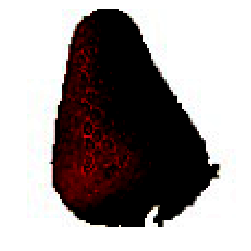

In [278]:
example, no = next(iter(train_loader))
img = example[0]
label = no[0]

ov = OcclusionVisualizer(model_loaded)
ov.fruitImShow(img.permute([1, 2, 0]))

done 0.00 procent
done 25.00 procent
done 50.00 procent
done 75.00 procent


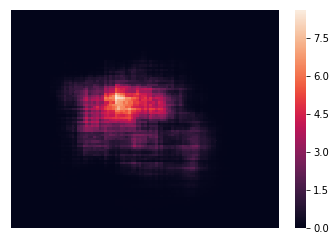

In [279]:
result = ov.drawOcclusionHeatMap(img, label)

In [213]:
count = 0
window_size = 10
result = np.zeros([100, 100])
for x in range(100):
    for y in range(100):
        # Occlude the image
        count += 1
        tmp_img = torch.zeros(list(img.size())).copy_(img)
        
        occluded_positions = ((x + a, y + b) 
                      for a in range(-window_size, window_size + 1) 
                      for b in range(-window_size, window_size + 1)
                      if 0 <= x + a <= 99 and 0 <= y + b <= 99)
        
        for occluded_position in occluded_positions:
            tmp_img[(slice(None),) + occluded_position] = torch.Tensor([1., 1., 1.])
        
        # Compute the loss on occluded image
        criterion = nn.CrossEntropyLoss()
        output = model_loaded(tmp_img.unsqueeze(0))
        loss = criterion(output.unsqueeze(0), label.unsqueeze(0))
        result[x, y] = loss.item()
        
        if count % 1000 == 999:
            print('progress...')
        
"""        if count % 250 == 249:
            print(loss)
            fruitImShow(tmp_img.permute([1, 2, 0]))
        
        if count > 1000:
            break"""


progress...
progress...
progress...
progress...
progress...
progress...
progress...
progress...
progress...
progress...


'        if count % 250 == 249:\n            print(loss)\n            fruitImShow(tmp_img.permute([1, 2, 0]))\n        \n        if count > 1000:\n            break'

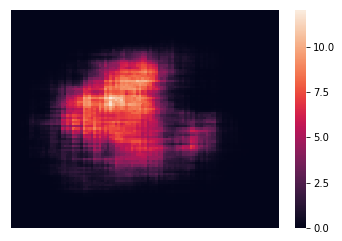

In [225]:
sns.heatmap(result - 0.008087158203125,
            xticklabels=False,
            yticklabels=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


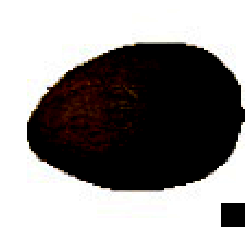

In [212]:
fruitImShow(tmp_img.permute([1, 2, 0]))

In [9]:
example.size()

torch.Size([128, 3, 100, 100])

In [10]:
tmp = example
print(tmp.size())
tmp = nn.Conv2d(3, 8, 5)(tmp)
print(tmp.size())
tmp = nn.MaxPool2d((2,2))(tmp)
print(tmp.size())
tmp = nn.Conv2d(8, 16, 11)(tmp)
print(tmp.size())
print(tmp.view(4,-1, 16 * 38 * 38).size())
tmp = nn.MaxPool2d(2,2)(tmp)
print(tmp.size())

torch.Size([128, 3, 100, 100])
torch.Size([128, 8, 96, 96])
torch.Size([128, 8, 48, 48])
torch.Size([128, 16, 38, 38])
torch.Size([4, 32, 23104])
torch.Size([128, 16, 19, 19])


# Testing zone: Keep away! You enter at your own risk. 

In [31]:
x = torch.tensor([[[[ 0.4801, -1.0264],
          [-0.6684, -0.0054]],

         [[-0.3160, -0.1503],
          [-0.8476,  0.9424]],

         [[-0.5158,  0.4040],
          [ 1.5077, -0.5627]]],


        [[[-1.1366,  0.7921],
          [ 1.4411, -1.6859]],

         [[-0.6283,  0.7755],
          [ 0.7855,  0.6781]],

         [[ 0.2961, -0.6014],
          [ 0.8488, -2.1111]]]])

In [32]:
mbn = MyBatchNormalization2d(2)
mbn.forward(x)

tensor([[[[ 0.6993, -0.7923],
          [-0.4379,  0.2186]],

         [[-0.7010, -0.4543],
          [-1.4924,  1.1723]],

         [[-0.4095,  0.4788],
          [ 1.5446, -0.4547]]],


        [[[-0.9015,  1.0082],
          [ 1.6508, -1.4453]],

         [[-1.1659,  0.9238],
          [ 0.9387,  0.7788]],

         [[ 0.3746, -0.4921],
          [ 0.9083, -1.9500]]]])

In [133]:
x = torch.Tensor([[ 0.3534,  1.3480,  1.0362],
        [-1.6341, -0.5642, -0.9382],
        [-0.4853, -0.3669, -0.1098],
        [-1.4520, -0.1399,  0.0106],
        [ 1.3992, -0.1157, -0.3049],
        [ 0.0403, -0.1023,  0.0091],
        [ 0.7643,  0.0948,  1.3555],
        [ 1.7898,  0.9649, -1.7940]])
print('input')
print(x)

mbn1d = MyBatchNormalization1d(3)
mbn1d.forward(x)

input
tensor([[ 0.3534,  1.3480,  1.0362],
        [-1.6341, -0.5642, -0.9382],
        [-0.4853, -0.3669, -0.1098],
        [-1.4520, -0.1399,  0.0106],
        [ 1.3992, -0.1157, -0.3049],
        [ 0.0403, -0.1023,  0.0091],
        [ 0.7643,  0.0948,  1.3555],
        [ 1.7898,  0.9649, -1.7940]])


tensor([[ 0.0466,  0.3784,  0.5910],
        [-0.3145, -0.2205, -0.4434],
        [-0.1058, -0.1587, -0.0094],
        [-0.2814, -0.0876,  0.0537],
        [ 0.2366, -0.0800, -0.1116],
        [-0.0103, -0.0758,  0.0529],
        [ 0.1212, -0.0141,  0.7583],
        [ 0.3075,  0.2584, -0.8917]], grad_fn=<AddBackward0>)

In [447]:
torch.device("cuda:0" if torch.cuda.is_available() else "cpu").__str__()

'cuda:0'

In [92]:
x = torch.randn(4,4)
mask = torch.diag(torch.ones(4))
out = mask * torch.diag(torch.zeros(4)) + (1. - mask) * x
print(mask)
print(out)
print(x)
print(torch.diag(x))

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])
tensor([[ 0.0000, -0.7406, -1.3640,  0.5907],
        [ 0.3773,  0.0000, -1.7041, -0.8587],
        [-0.7173,  0.0738,  0.0000,  0.3572],
        [-1.3948, -1.5232, -0.4627,  0.0000]])
tensor([[-0.6915, -0.7406, -1.3640,  0.5907],
        [ 0.3773, -0.7853, -1.7041, -0.8587],
        [-0.7173,  0.0738, -2.1117,  0.3572],
        [-1.3948, -1.5232, -0.4627, -2.2673]])
tensor([-0.6915, -0.7853, -2.1117, -2.2673])


In [390]:
a = (1,2,3,4)
b = (-1,-2,-3)
list(zip(a, a[1:], b))

[(1, 2, -1), (2, 3, -2), (3, 4, -3)]

In [11]:
! ls -R /home/md359230/DeepLearning/assignment1/data/fruits-360/Training/ | wc -l

49191


In [12]:
! ls -R /home/md359230/DeepLearning/assignment1/data/fruits-360/Test/ | wc -l

16707
